In [1]:
import numpy as np
import os
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import platform
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from skimage import morphology, feature, transform, filters, exposure

In [34]:
try:
    from shapes import *
    from detect_bubbles import *
    from utils import *
except ImportError:
    print("Import warning")
    pass

Import warning


In [3]:
from classify_bubble import *
from bubbleNet1D import *

/Users/Habib/anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
%load_ext autoreload
%autoreload 2

In [65]:
def init_figure(frameon=False, figsize=(6,6)):
    fig = plt.figure(frameon, figsize)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

In [69]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

In [6]:
def show_bubble_circle(image, circ, color="red"):
    fig1 = plt.figure(figsize=(8,8))
    ax1 = fig1.add_subplot(111, aspect='equal')
    plt.imshow(image, cmap="gray")
    ax1.add_patch(
                patches.Circle(
                    (circ.y, circ.x),   
                    circ.radius,
                    fill=False,
                    color=color))

In [7]:
plat = platform.system()
if plat == "Darwin":
    calib_dir =  "/Users/Habib/Google Drive/Uni Heidelberg/11 WS 2017-2018/Masterarbeit/Messungen/Reihe_32_calib_radius" 
elif plat == "Windows":
    calib_dir = "../Messungen/Reihe_32_calib_radius/"

In [8]:
cim = []
bgim = []
filenames = []
for file in os.listdir(calib_dir):
    filenames.append(file)

filenames.sort() # sort after creation date since date is in the name

In [9]:
cim = []
bgim = []
for file in filenames[1:]:
    if file.endswith(".bmp"):
        if int(file[-5:-4])%2 ==0:
            img = cv2.imread(os.path.join(calib_dir, file), 0)
            cim.append(img)
        else:
            img = cv2.imread(os.path.join(calib_dir, file), 0)
            bgim.append(img)

## The algorithm -> Radius calibration -> green radius

In [10]:
green_bubble =  bgim[0][75:135, 675:730]

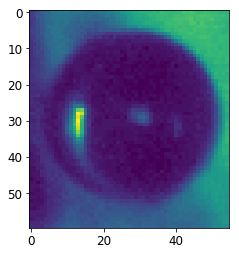

In [11]:
plt.imshow(green_bubble)

In [12]:
edges = filters.sobel(green_bubble)

In [13]:
edges_profile = np.loadtxt("../thesis/extern/edges_profile.csv", skiprows=1, delimiter=",")

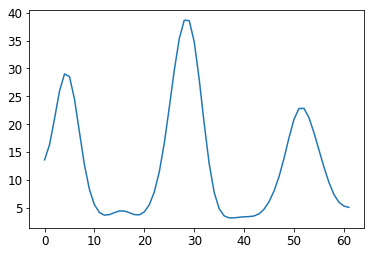

In [14]:
from scipy.ndimage.filters import gaussian_filter1d
ydata = gaussian_filter1d(edges_profile.T[1], sigma=2)
plt.plot(ydata)

In [15]:
xdata = np.arange(0, len(ydata))

In [16]:
def gauss(x, a, mu, sigma):
    return a * np.exp(- (x - mu)**2/sigma**2)

In [17]:
popt1, _ = curve_fit(gauss, xdata, ydata, p0=[30, 5, 2])
popt2, _ = curve_fit(gauss, xdata, ydata, p0=[30, 56, 2])

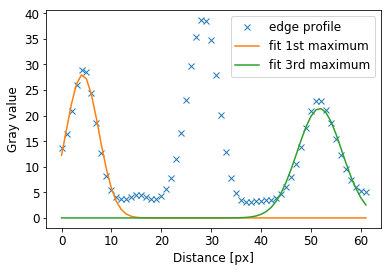

In [79]:
fig = plt.figure(frameon=False)
fig.set_size_inches(6,4)
plt.plot(ydata, 'x', label="edge profile")
plt.plot(xdata, gauss(xdata, *popt1), label="fit 1st maximum")
plt.plot(xdata, gauss(xdata, *popt2), label="fit 3rd maximum")
plt.xlabel("Distance [px]")
plt.ylabel("Gray value")
plt.legend()
plt.savefig("../thesis/graphs/green_radius_demo.png")

# The algorithm -> radius calibration -> factor

In [19]:
# data from radius_calibration.ipynb

red_radii = []
green_radii = []

red_radii.append( [15.5, 15, 16, 16, 15.5, 16])
green_radii.append( [19.35, 20.05, 20.02, 20.09])

red_radii.append( [7, 7.5, 6, 7.5, 7.5, 7, 7.5, 6.5] )
green_radii.append( [12.09, 11.22, 12.07, 11.02])

red_radii.append([11.5, 11, 11.5])
green_radii.append( [14.07, 14.87, 15] )

red_radii.append([9, 9.5, 9.5, 9, 9.5, 10])
green_radii.append([13.06, 13.93, 14.01] )



In [20]:
x_data = [np.mean(r) for r in red_radii]
y_data = [np.mean(g) for g in green_radii]
y_err = [np.std(r) for r in red_radii]
x_err = [np.std(g) for g in green_radii]

In [21]:
def lin(x, a, b):
    return a*x +b

In [22]:
popt_lin, _ = curve_fit(lin, x_data, y_data)

In [23]:
popt_lin

array([0.95690246, 4.54637797])

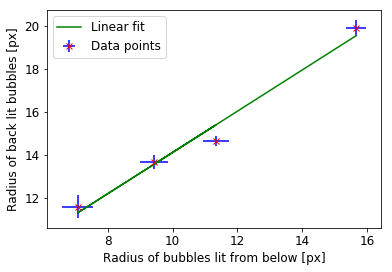

In [209]:
plt.errorbar(x_data, y_data, xerr=x_err, yerr=y_err, fmt='rx', ecolor='b', label="Data points")
plt.plot(x_data, lin(np.asarray(x_data), *popt_lin), 'g', label="Linear fit")
plt.xlabel("Radius of bubbles lit from below [px]")
plt.ylabel("Radius of back lit bubbles [px]")
plt.legend()
plt.savefig("../thesis/graphs/radius_calibration_result.png")

# 2.2.4 Edges and Derivation

In [25]:
red_bubb = transform.rotate(cim[0][580:630, 500:550], 90)

In [26]:
gb = np.flip(green_bubble.T, axis=0)

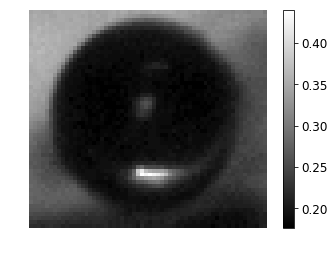

In [27]:
plt.imshow(gb/255, cmap="gray")
_ = plt.axis('off')
plt.colorbar()
#plt.savefig("../thesis/images/green_one.png")

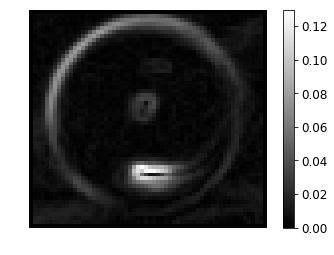

In [28]:
plt.imshow(filters.sobel( gb/255), cmap="gray")
_ = plt.axis('off')
plt.colorbar()
#plt.savefig("../thesis/images/green_one_sobel.png")

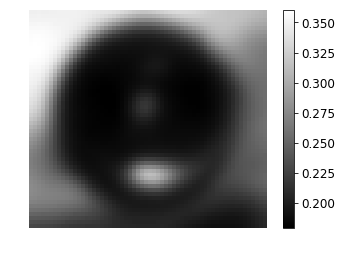

In [29]:
plt.imshow(filters.gaussian(gb, sigma=2), cmap="gray")
_ = plt.axis('off')
plt.colorbar()
#plt.savefig("../thesis/images/green_one_gaussian.png")

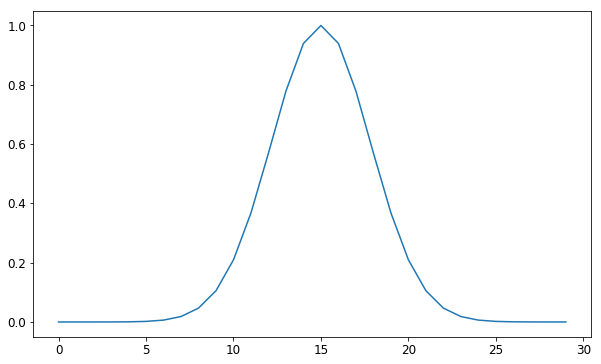

In [30]:
xx = np.arange(0, 30)
yy = gauss(x=xx, a=1, sigma=4, mu=15)
plt.figure(figsize=(10,6))
plt.plot(yy)
#plt.savefig("../thesis/graphs/gauss_sigma_4.png")

# 2.2.5 Orientation and structure tensor

In [31]:
mess_small = [cv2.imread( os.path.join("data", filename), 0) for filename in os.listdir("data") if filename.endswith("png")]

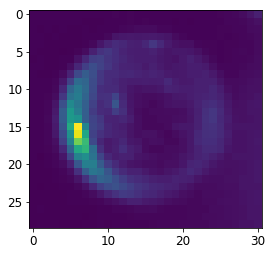

In [55]:
im = mess_small[1]
plt.imshow(im)

In [48]:
import utils

In [49]:
size = 31
xx = np.linspace(0,10, size)
yy = np.linspace(0,10, size)
XX, YY = np.meshgrid(xx, yy)
smooth_mask = utils.gauss_2d_mask([XX,YY], amp=10, mu=[5,5], sigma=[1,1])

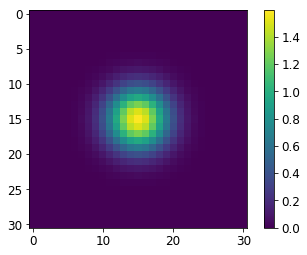

In [50]:
plt.imshow(smooth_mask)
plt.colorbar()

In [56]:
Axx, Axy, Ayy = utils.my_structure_tensor(im, smooth_mask)

In [87]:
gamma_adjusted = exposure.adjust_gamma(im, 0.1)
gamma_adjusted = np.flip(gamma_adjusted.T, axis=0)
Axx, Axy, Ayy = utils.my_structure_tensor(gamma_adjusted, smooth_mask)

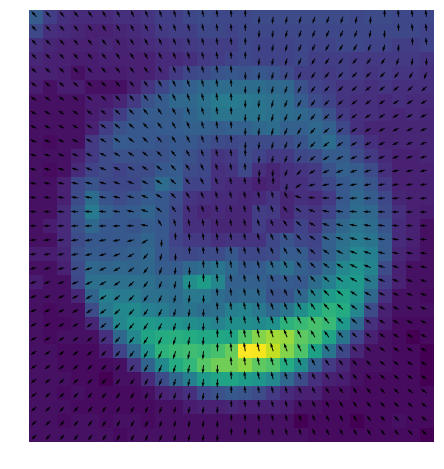

In [88]:
fig = plt.figure(frameon=False, figsize=(6,6))
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

n, m = Axx.shape 
X, Y = np.mgrid[0:n, 0:m]
T = .5 * np.arctan2(2 * Axy, Ayy-Axx)
R = np.ones((gamma_adjusted.shape)) * gamma_adjusted
U, V = R * (-np.cos(T)), R * (np.sin(T))
_ = plt.quiver(U, V, linewidths=2)
_ = plt.imshow(gamma_adjusted)
#plt.savefig("../thesis/images/structure_tensor_demo.png")

# 2.3 Object detection problem

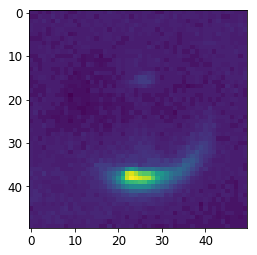

In [35]:
plt.imshow(red_bubb)

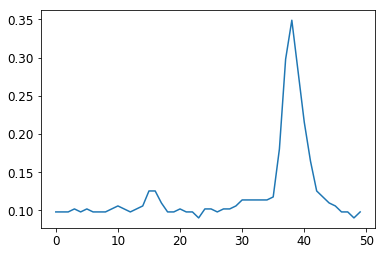

In [46]:
plt.plot(red_bubb[:,25])
#plt.savefig("../thesis/graphs/red_profile_1.png")

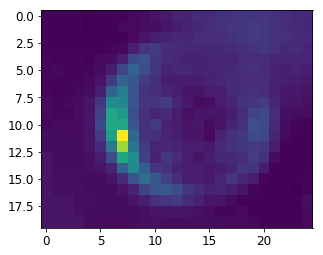

In [41]:
plt.imshow(mess_small[4])

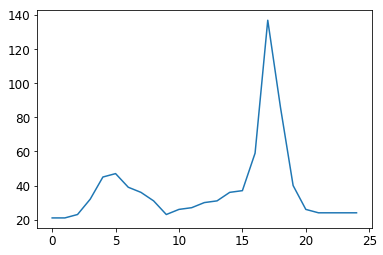

In [45]:
plt.plot(np.flip(mess_small[4][11,:], axis=0))
#plt.savefig("../thesis/graphs/red_profile_2.png")

In [61]:
one_peaks = cv2.imread("../thesis/images/one_peaks.png", 0)

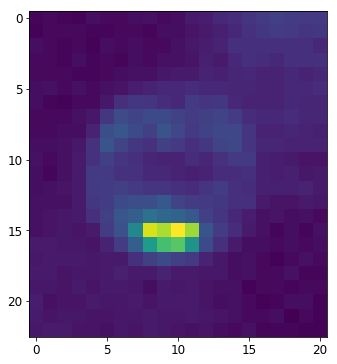

In [72]:
plt.figure(figsize=(6,6))
plt.imshow(one_peaks)
#plt.savefig("../thesis/images/one_peaks_color.png")

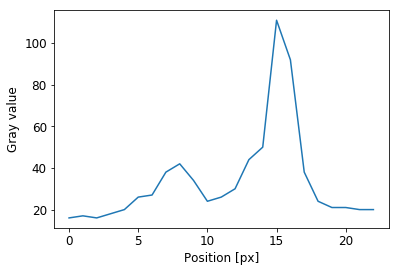

In [77]:
plt.figure(figsize=(6,4))
plt.plot(one_peaks[:,9])
plt.xlabel("Position [px]")
plt.ylabel("Gray value")
#plt.savefig("../thesis/graphs/one_peaks_profile.png")

# 5.3.2 Radius from orientation

In [80]:
one = cv2.imread("data/one_mess.png", 0)

In [81]:
Axx, Axy, Ayy = utils.my_structure_tensor(one, smooth_mask)

In [128]:
gamma_adjusted = exposure.adjust_gamma(one, 1)
gamma_adjusted = np.flip(gamma_adjusted.T, axis=0)
Axx, Axy, Ayy = utils.my_structure_tensor(gamma_adjusted, smooth_mask)

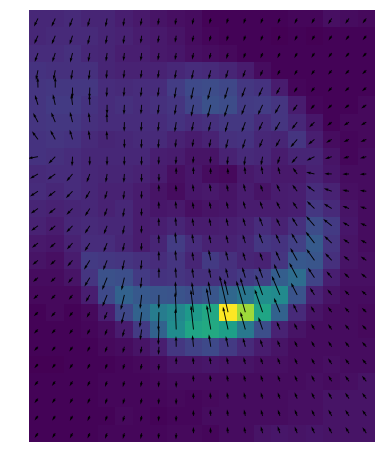

In [129]:
fig = plt.figure(frameon=False, figsize=(6,6))
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

n, m = Axx.shape 
X, Y = np.mgrid[0:n, 0:m]
T = .5 * np.arctan2(2 * Axy, Ayy-Axx)
R = np.ones((gamma_adjusted.shape)) * gamma_adjusted
U, V = R * (-np.cos(T)), R * (np.sin(T))
_ = plt.quiver(U, V, linewidths=2)
_ = plt.imshow(gamma_adjusted)
plt.savefig("../thesis/images/struct_tensor_result_2.png")

label: fig:struct_tensor_result

In [87]:
gamma_adjusted = exposure.adjust_gamma(im, 0.1)
gamma_adjusted = np.flip(gamma_adjusted.T, axis=0)
Axx, Axy, Ayy = utils.my_structure_tensor(gamma_adjusted, smooth_mask)

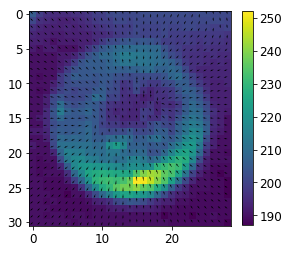

In [125]:
fig = plt.figure(frameon=False, figsize=(4,4))

n, m = Axx.shape 
X, Y = np.mgrid[0:n, 0:m]
T = .5 * np.arctan2(2 * Axy, Ayy-Axx)
R = np.ones((gamma_adjusted.shape)) * gamma_adjusted
U, V = R * (-np.cos(T)), R * (np.sin(T))
_ = plt.quiver(U, V, linewidths=2)
_ = plt.imshow(gamma_adjusted)
plt.colorbar(fraction=0.048)
plt.savefig("../thesis/images/struct_tensor_orientation.png")

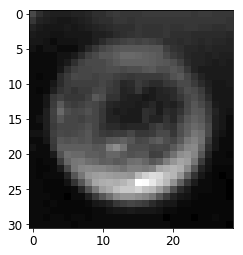

In [126]:
fig = plt.figure(frameon=False, figsize=(4,4))
plt.imshow(gamma_adjusted, cmap="gray")
plt.savefig("../thesis/images/struct_tensor_original.png")

In [92]:
l1, l2 = feature.structure_tensor_eigvals(Axx, Axy, Ayy)

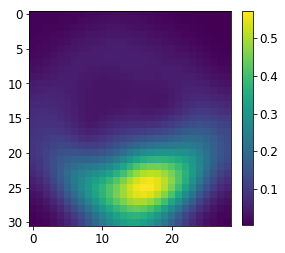

In [117]:
plt.figure(figsize=(4,4))
plt.imshow(l1)
plt.colorbar(fraction=0.048)
plt.savefig("../thesis/images/larger_ev.png")

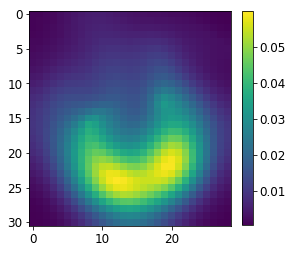

In [118]:
plt.figure(figsize=(4,4))
plt.imshow(l2)
plt.colorbar(fraction=0.048)
plt.savefig("../thesis/images/smaller_ev.png")

# 5.2.2 Signal extraction

In [172]:
render_dir = "../ring_ansatz/renders/"
pickle_paths = []
png_path = []
for filename in os.listdir(render_dir):
    if filename.endswith(".pickle"):
        pickle_paths.append(os.path.join(render_dir, filename))
        
        
            
    elif filename.endswith(".png"):
        png_path.append(os.path.join(render_dir, filename))
        
        
        


In [173]:
pickle_paths.sort()
png_path.sort()

In [175]:
radii = []
profiles = []
for pp in pickle_paths:
    with open(pp, "rb") as handle:
        lb = pickle.load(handle)
        radii.append((lb[0]["xmax"] - lb[0]["xmin"]) / 2)
for pp in png_path:
    rd = cv2.imread(pp, 0)
    profiles.append(rd[20])

In [134]:
from scipy.signal import argrelextrema
from scipy.ndimage.filters import gaussian_filter1d

In [176]:
smoothed_profiles = [gaussian_filter1d(profile, sigma=1) for profile in profiles]

In [177]:
peaks = [argrelextrema(sp, np.greater)[0] for sp in smoothed_profiles]


In [181]:
dist_peaks = [np.nan] * len(peaks)
for idx, p in enumerate(peaks):
    if p.shape==(2,):
        dist_peaks[idx] = np.abs(p[1] - p[0])

In [202]:
invalid = np.isnan(dist_peaks)
valid = np.invert(invalid)

In [203]:
radii = np.asarray(radii)
dist_peaks = np.asarray(dist_peaks)
popt, _ = curve_fit(lin, radii[valid], dist_peaks[valid])

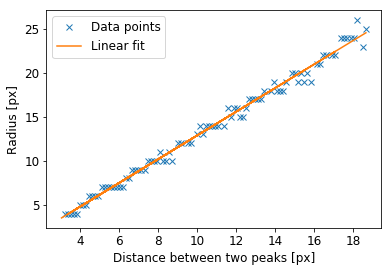

In [207]:
plt.figure()
plt.plot(radii, dist_peaks, 'x', label="Data points")
plt.plot(radii, lin(radii, *popt), label="Linear fit")
plt.xlabel("Distance between two peaks [px]")
plt.ylabel("Radius [px]")
plt.legend()
plt.savefig("../thesis/graphs/peak_distance_radius_fit.png")